# Lawmaker Tracking Exploratory Analysis
Continuation of https://github.com/chaseabrown/Jupyter-Notebooks/blob/main/Lawmaker%20Tracking%20Data%20Preprocessing.ipynb

## Imports

In [30]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import random
import io
import re
import numpy as np
from pathlib import Path
import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')
marketDays = nyse.valid_days(start_date='2014-1-1', end_date='2021-12-22')
import warnings
warnings.filterwarnings('ignore')
import traceback
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost
from xgboost import XGBRegressor, DMatrix
from statsmodels.tsa.seasonal import seasonal_decompose

## Methods

## Read in Data

In [2]:
combinedData = pd.read_csv("stocks_and_lawmakers.csv")
combinedData = combinedData.set_index('ID')
combinedData

,Date,Name,Adj Close,Close,High,Low,Open,Volume,Close_DB,Open_DB,...,David_A_Perdue__Jr,Roger_F_Wicker,Tina_Smith,John_Hoeven,John_N_Kennedy,Rafael_E_Cruz,Christopher_A_Coons,Thomas_Udall,John_F_Reed,Thomas_R_Tillis
ID,,,,,,,,,,,,,,,,,,,,,
2019-01-04-BP,2019-01-04,BP,38.959999,40.080002,39.419998,40.029999,33.186440,9336700.0,39.060001,32.175011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07-BP,2019-01-07,BP,39.570000,40.310001,39.580002,40.160000,33.294216,6114300.0,40.080002,33.186440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-08-BP,2019-01-08,BP,39.700001,40.259998,39.830002,40.029999,33.186440,5654900.0,40.310001,33.294216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-09-BP,2019-01-09,BP,40.180000,40.610001,40.150002,40.360001,33.460022,6914500.0,40.259998,33.186440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-10-BP,2019-01-10,BP,40.389999,40.759998,40.130001,40.700001,33.741898,4822500.0,40.610001,33.460022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-11-BFK,2021-11-11,BFK,15.200000,15.210000,15.030000,15.080000,14.963800,25500.0,15.250000,14.904263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-12-BFK,2021-11-12,BFK,15.060000,15.160000,15.050000,15.110000,15.051961,44300.0,15.210000,14.963800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-15-BFK,2021-11-15,BFK,15.080000,15.210000,15.120000,15.180000,15.121693,40900.0,15.160000,15.051961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Analysis

In [3]:
tickers = combinedData['Name'].unique()
len(tickers)

1569

In [4]:
combinedData['action_date'].unique()

array([nan, '2019-12-17', '2019-12-23', '2020-01-06', '2020-01-08',
       '2020-03-04', '2020-03-30', '2020-03-31', '2020-04-01',
       '2020-04-07', '2020-04-14', '2020-04-16', '2020-05-01',
       '2020-05-08', '2020-06-22', '2020-07-08', '2020-09-28',
       '2020-10-05', '2020-11-13', '2020-12-02', '2020-12-21',
       '2021-01-08', '2021-01-22', '2021-03-29', '2021-04-07',
       '2021-09-27', '2021-10-04', '2021-11-03', '2019-01-08',
       '2019-01-25', '2019-02-21', '2019-05-15', '2019-06-10',
       '2019-07-10', '2019-08-07', '2019-09-25', '2019-09-30',
       '2019-10-11', '2019-10-21', '2019-11-04', '2019-11-05',
       '2019-11-14', '2019-11-20', '2019-12-03', '2019-12-05',
       '2020-01-07', '2020-02-14', '2020-03-10', '2020-03-12',
       '2020-03-16', '2020-03-26', '2020-03-28', '2020-04-06',
       '2020-05-05', '2020-06-10', '2020-07-20', '2020-07-22',
       '2020-08-15', '2020-08-18', '2020-08-21', '2020-08-29',
       '2020-09-10', '2020-09-16', '2020-10-15', '

In [5]:
for i in range(0,len(combinedData.columns.values)):
    print(i, combinedData.columns.values[i])

0 Date
1 Name
2 Adj Close
3 Close
4 High
5 Low
6 Open
7 Volume
8 Close_DB
9 Open_DB
10 High_DB
11 Low_DB
12 Volume_DB
13 Close_Average_Week
14 Close_Average_Month
15 Close_Average_3Month
16 Close_Average_Year
17 Close_AVGRatio_Week_Month
18 Close_AVGRatio_Week_3Month
19 Close_AVGRatio_Week_Year
20 Close_AVGRatio_Month_3Month
21 Close_AVGRatio_Month_Year
22 Close_AVGRatio_3Month_Year
23 Volume_Average_Week
24 Volume_Average_Month
25 Volume_Average_3Month
26 Volume_Average_Year
27 Volume_AVGRatio_Week_Month
28 Volume_AVGRatio_Week_3Month
29 Volume_AVGRatio_Week_Year
30 Volume_AVGRatio_Month_3Month
31 Volume_AVGRatio_Month_Year
32 Volume_AVGRatio_3Month_Year
33 Close_STD_Week
34 Close_STD_Month
35 Close_STD_3Month
36 Close_STD_Year
37 Close_STDRatio_Week_Month
38 Close_STDRatio_Week_3Month
39 Close_STDRatio_Week_Year
40 Close_STDRatio_Month_3Month
41 Close_STDRatio_Month_Year
42 Close_STDRatio_3Month_Year
43 Day_Return
44 Week_Return
45 Month_Return
46 Quarter_Return
47 Year_Return
48 Day

--------------------------------------- ABBV ---------------------------------------
1 RMSE: 13.006  | 2 RMSE: 13.607
1 MAE: 11.464  | 2 MAE: 11.973
1 R^2: -0.847  | 2 R^2: -1.021

1 RMSE (MEAN): 13.006  | 2 RMSE (MEAN): 13.607
1 MAE: (MEAN): 11.464  | 2 MAE (MEAN): 11.973
1 R^2: (MEAN): -0.847  | 2 R^2 (MEAN): -1.021


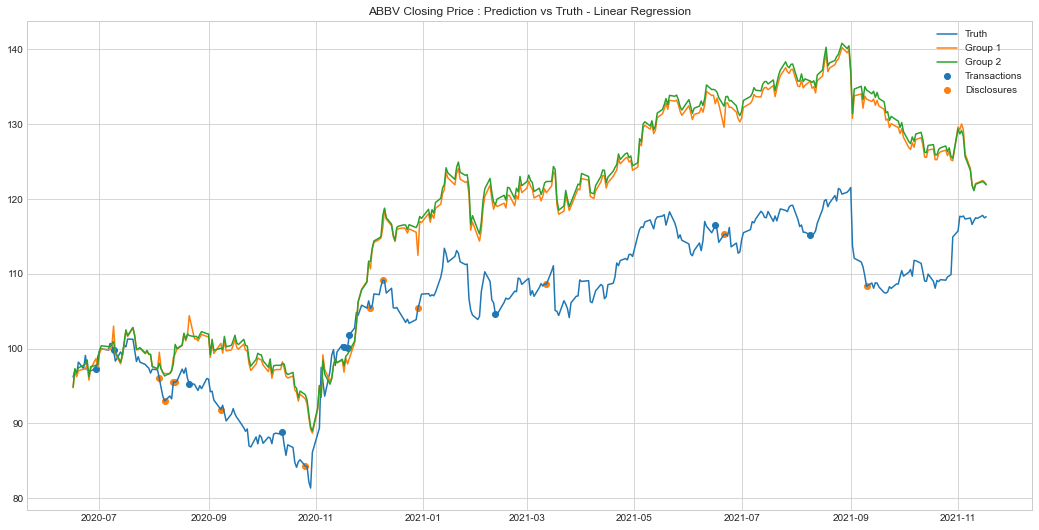

--------------------------------------- ABBV ---------------------------------------
--------------------------------------- KUBTY ---------------------------------------
1 RMSE: 19.281  | 2 RMSE: 19.286
1 MAE: 14.456  | 2 MAE: 14.442
1 R^2: -0.994  | 2 R^2: -0.995

1 RMSE (MEAN): 16.143  | 2 RMSE (MEAN): 16.447
1 MAE: (MEAN): 12.960  | 2 MAE (MEAN): 13.207
1 R^2: (MEAN): -0.920  | 2 R^2 (MEAN): -1.008


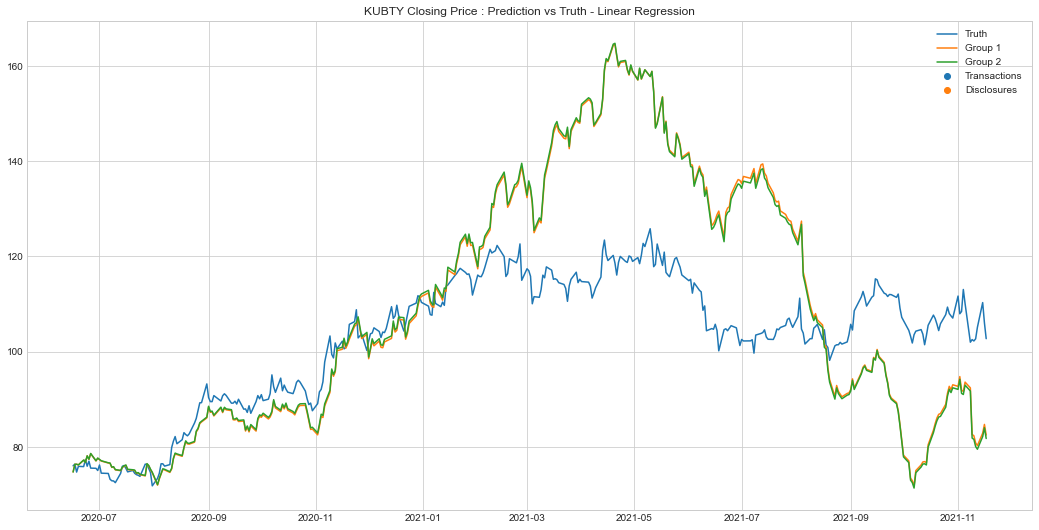

--------------------------------------- KUBTY ---------------------------------------
--------------------------------------- ISD ---------------------------------------
1 RMSE: 1.444  | 2 RMSE: 1.462
1 MAE: 1.353  | 2 MAE: 1.371
1 R^2: -0.852  | 2 R^2: -0.901

1 RMSE (MEAN): 11.243  | 2 RMSE (MEAN): 11.452
1 MAE: (MEAN): 9.091  | 2 MAE (MEAN): 9.262
1 R^2: (MEAN): -0.898  | 2 R^2 (MEAN): -0.972


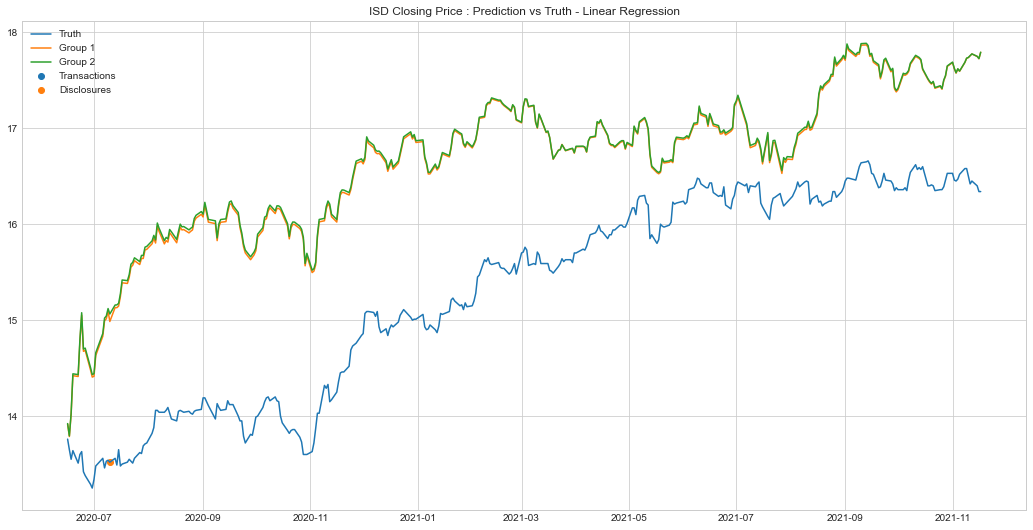

--------------------------------------- ISD ---------------------------------------
--------------------------------------- AON ---------------------------------------
1 RMSE: 32.483  | 2 RMSE: 32.243
1 MAE: 22.281  | 2 MAE: 22.595
1 R^2: 0.187  | 2 R^2: 0.199

1 RMSE (MEAN): 16.553  | 2 RMSE (MEAN): 16.650
1 MAE: (MEAN): 12.388  | 2 MAE (MEAN): 12.595
1 R^2: (MEAN): -0.626  | 2 R^2 (MEAN): -0.679


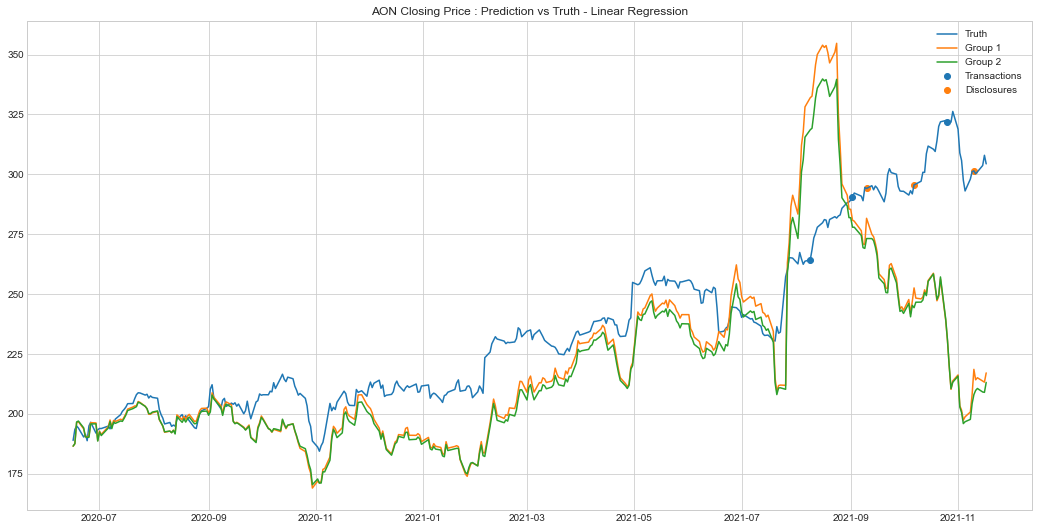

--------------------------------------- AON ---------------------------------------
--------------------------------------- BALY ---------------------------------------
1 RMSE: 6948.574  | 2 RMSE: 6948.574
1 MAE: 5508.748  | 2 MAE: 5508.748
1 R^2: -215185.551  | 2 R^2: -215185.551

1 RMSE (MEAN): 1402.958  | 2 RMSE (MEAN): 1403.035
1 MAE: (MEAN): 1111.660  | 2 MAE (MEAN): 1111.826
1 R^2: (MEAN): -43037.611  | 2 R^2 (MEAN): -43037.654


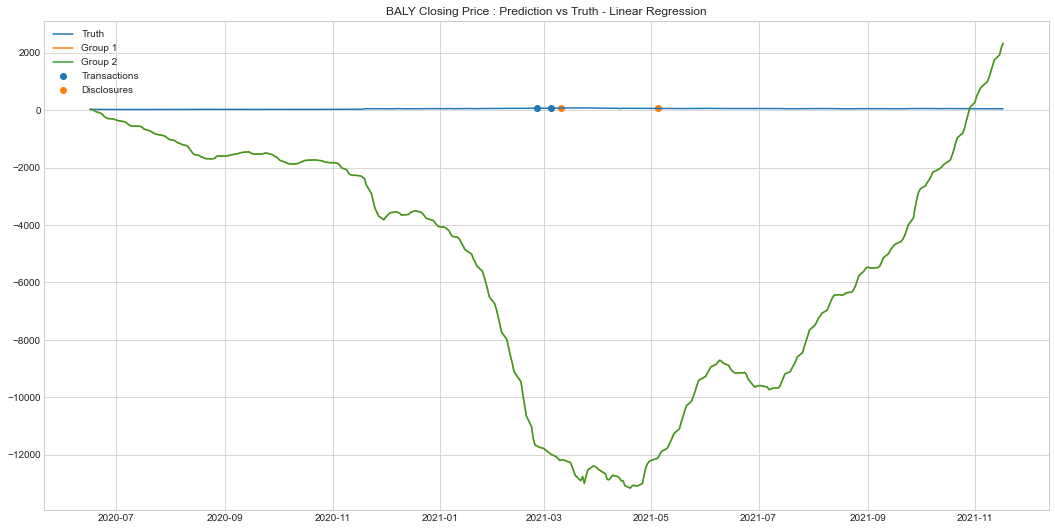

--------------------------------------- BALY ---------------------------------------
--------------------------------------- BGS ---------------------------------------
1 RMSE: 9.860  | 2 RMSE: 9.860
1 MAE: 9.447  | 2 MAE: 9.447
1 R^2: -12.388  | 2 R^2: -12.388

1 RMSE (MEAN): 1170.775  | 2 RMSE (MEAN): 1170.839
1 MAE: (MEAN): 927.958  | 2 MAE (MEAN): 928.096
1 R^2: (MEAN): -35866.741  | 2 R^2 (MEAN): -35866.776


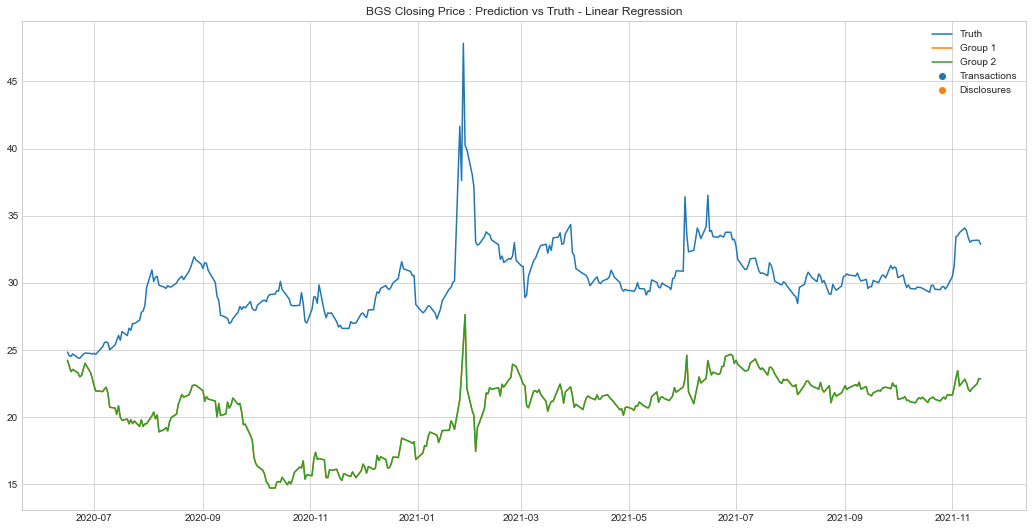

--------------------------------------- BGS ---------------------------------------
--------------------------------------- POWI ---------------------------------------
1 RMSE: 13.705  | 2 RMSE: 13.705
1 MAE: 10.186  | 2 MAE: 10.186
1 R^2: 0.320  | 2 R^2: 0.320

1 RMSE (MEAN): 1005.479  | 2 RMSE (MEAN): 1005.534
1 MAE: (MEAN): 796.848  | 2 MAE (MEAN): 796.966
1 R^2: (MEAN): -30742.875  | 2 R^2 (MEAN): -30742.905


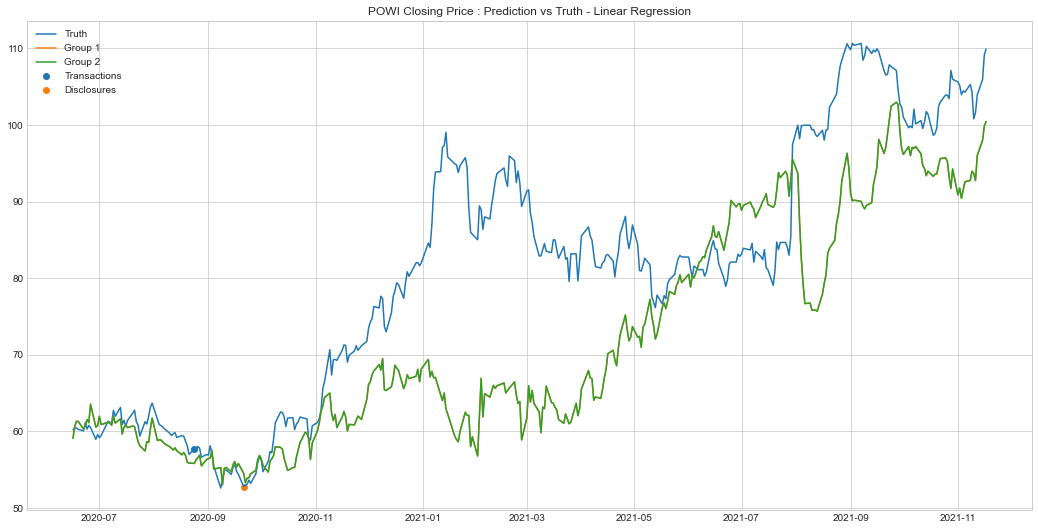

--------------------------------------- POWI ---------------------------------------
--------------------------------------- VEEV ---------------------------------------
1 RMSE: 16.460  | 2 RMSE: 16.590
1 MAE: 12.829  | 2 MAE: 12.974
1 R^2: 0.587  | 2 R^2: 0.580

1 RMSE (MEAN): 881.852  | 2 RMSE (MEAN): 881.916
1 MAE: (MEAN): 698.845  | 2 MAE (MEAN): 698.967
1 R^2: (MEAN): -26899.942  | 2 R^2 (MEAN): -26899.970


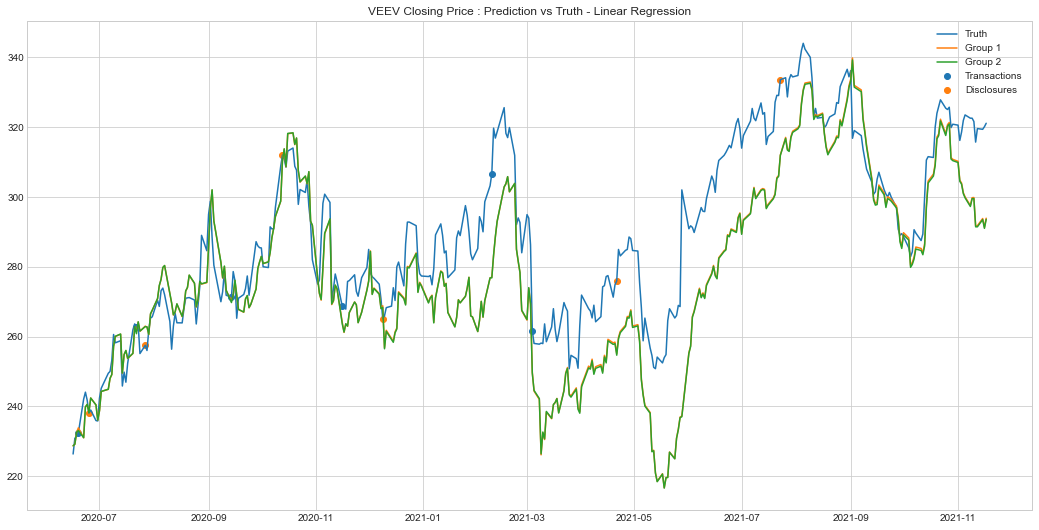

--------------------------------------- VEEV ---------------------------------------
--------------------------------------- PRIM ---------------------------------------
1 RMSE: 5.902  | 2 RMSE: 5.722
1 MAE: 4.736  | 2 MAE: 4.587
1 R^2: 0.066  | 2 R^2: 0.123

1 RMSE (MEAN): 784.524  | 2 RMSE (MEAN): 784.561
1 MAE: (MEAN): 621.722  | 2 MAE (MEAN): 621.814
1 R^2: (MEAN): -23911.052  | 2 R^2 (MEAN): -23911.070


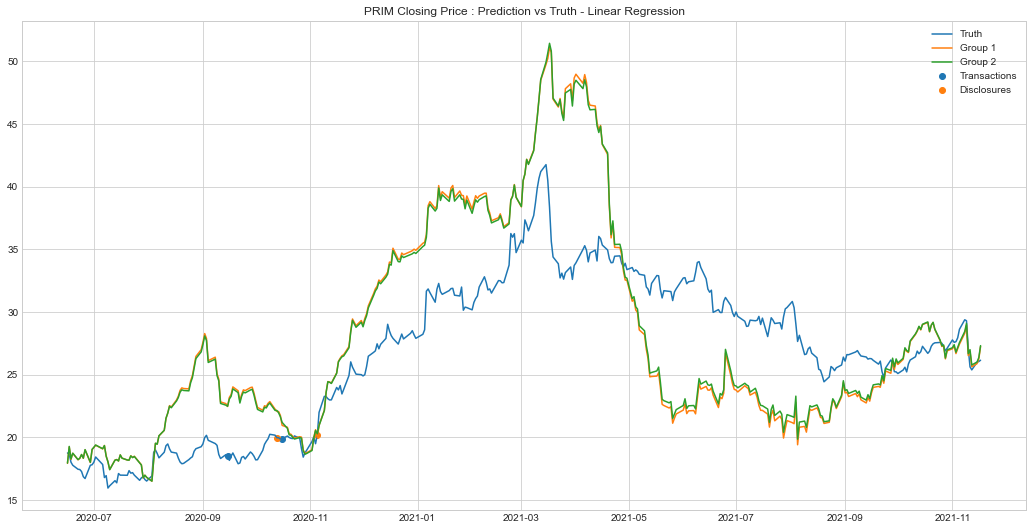

--------------------------------------- PRIM ---------------------------------------


In [34]:
logColumns=["Ticker", "Group", "RMSE", "MAE", "R2"]
logsdf = pd.DataFrame(columns=logColumns)

for ticker in random.sample(list(tickers),10):
    # Group 1: With Lawmaker Data 
    tempDF = combinedData[combinedData['Name']==ticker].dropna(subset=["Close"])
    try:
        tempDF['Date'] = pd.to_datetime(tempDF['Date'])
        tempDF = tempDF.set_index('Date')
        tempDF = tempDF.sort_index()
        x = tempDF.drop(tempDF.columns.values[:6],
                    axis=1).drop(tempDF.columns.values[51:66],
                    axis=1)
        y = tempDF.Close

        start = datetime.datetime(2019, 1, 1,0,0)
        end = datetime.datetime(2020, 6, 15, 0, 0)
        X_train1 = x.loc[start:end]
        y_train1 = y.loc[start:end]


        start = datetime.datetime(2020, 6, 16,0,0)
        end = datetime.datetime(2021, 12, 23, 0, 0)
        X_test1 = x.loc[start:end]
        y_test1 = y.loc[start:end]

        #Scaling the Data
        #Fit Scalar using training
        scaler = StandardScaler()
        scaler.fit(X_train1)

        #Rescale both using the fit scaler
        X_scaled_train1 = scaler.transform(X_train1)
        X_scaled_test1 = scaler.transform(X_test1)

        lin = LinearRegression()

        lin.fit(X_scaled_train1, y_train1)
        predictions_lin1 = lin.predict(X_scaled_test1)

        # Group 2: Without Lawmaker Data
        x = tempDF.drop(tempDF.columns.values[:6],
                    axis=1).drop(tempDF.columns.values[51:],
                    axis=1)
        y = tempDF.Close

        start = datetime.datetime(2019, 1, 1,0,0)
        end = datetime.datetime(2020, 6, 15, 0, 0)
        X_train2 = x.loc[start:end]
        y_train2 = y.loc[start:end]


        start = datetime.datetime(2020, 6, 16,0,0)
        end = datetime.datetime(2021, 12, 23, 0, 0)
        X_test2 = x.loc[start:end]
        y_test2 = y.loc[start:end]
        tempDFTest = tempDF.loc[start:end]

        #Scaling the Data
        #Fit Scalar using training
        scaler = StandardScaler()
        scaler.fit(X_train2)

        #Rescale both using the fit scaler
        X_scaled_train2 = scaler.transform(X_train2)
        X_scaled_test2 = scaler.transform(X_test2)

        lin = LinearRegression()

        lin.fit(X_scaled_train2, y_train2)
        predictions_lin2 = lin.predict(X_scaled_test2)


        print("---------------------------------------", ticker, "---------------------------------------")
        print('1 RMSE: {0:.3f}'.format(mean_squared_error(y_test1, predictions_lin1)**0.5), " | 2 RMSE: {0:.3f}".format(mean_squared_error(y_test2, predictions_lin2)**0.5))
        print('1 MAE: {0:.3f}'.format(mean_absolute_error(y_test1, predictions_lin1)), ' | 2 MAE: {0:.3f}'.format(mean_absolute_error(y_test2, predictions_lin2)))
        print('1 R^2: {0:.3f}'.format(r2_score(y_test1, predictions_lin1)), ' | 2 R^2: {0:.3f}'.format(r2_score(y_test2, predictions_lin2)))

        results1 = [[ticker], [1], [mean_squared_error(y_test1, predictions_lin1)**0.5], [mean_absolute_error(y_test1, predictions_lin1)], [r2_score(y_test1, predictions_lin1)]]
        results2 = [[ticker], [2], [mean_squared_error(y_test2, predictions_lin2)**0.5], [mean_absolute_error(y_test2, predictions_lin2)], [r2_score(y_test2, predictions_lin2)]]


        logsdf = logsdf.append(pd.DataFrame.from_dict(dict(zip(logColumns, results1))), ignore_index=True)
        logsdf = logsdf.append(pd.DataFrame.from_dict(dict(zip(logColumns, results2))), ignore_index=True)

        print()
        print('1 RMSE (MEAN): {0:.3f}'.format(logsdf[logsdf['Group']==1].RMSE.mean()), " | 2 RMSE (MEAN): {0:.3f}".format(logsdf[logsdf['Group']==2].RMSE.mean()))
        print('1 MAE: (MEAN): {0:.3f}'.format(logsdf[logsdf['Group']==1].MAE.mean()), " | 2 MAE (MEAN): {0:.3f}".format(logsdf[logsdf['Group']==2].MAE.mean()))
        print('1 R^2: (MEAN): {0:.3f}'.format(logsdf[logsdf['Group']==1].R2.mean()), " | 2 R^2 (MEAN): {0:.3f}".format(logsdf[logsdf['Group']==2].R2.mean()))

        datesT = tempDFTest[tempDFTest['transaction'] >= 1].index.values
        datesD = tempDFTest[tempDFTest['disclosure'] >= 1].index.values
        valuesT = tempDFTest[tempDFTest['transaction'] >= 1].Close
        valuesD = tempDFTest[tempDFTest['disclosure'] >= 1].Close
        dates = y_test1.index.values
        plt.figure(figsize = (18,9))
        plot_truth, = plt.plot(dates, y_test1)
        transactions = plt.scatter(datesT, valuesT)
        disclosures = plt.scatter(datesD, valuesD)
        plot_lin1, = plt.plot(dates, predictions_lin1)
        plot_lin2, = plt.plot(dates, predictions_lin2)
        plt.legend([plot_truth, plot_lin1, plot_lin2, transactions, disclosures], ['Truth', 'Group 1', 'Group 2', 'Transactions', 'Disclosures'])
        plt.title(ticker + ' Closing Price : Prediction vs Truth - Linear Regression')
        plt.show()
        print("---------------------------------------", ticker, "---------------------------------------")
    except:
        pass
    
    

In [7]:
eventData = combinedData[combinedData["action_date"].notna()]
eventData

,Date,Name,Adj Close,Close,High,Low,Open,Volume,Close_DB,Open_DB,...,David_A_Perdue__Jr,Roger_F_Wicker,Tina_Smith,John_Hoeven,John_N_Kennedy,Rafael_E_Cruz,Christopher_A_Coons,Thomas_Udall,John_F_Reed,Thomas_R_Tillis
ID,,,,,,,,,,,,,,,,,,,,,
2019-12-17-BP,2019-12-17,BP,37.480000,37.830002,37.470001,37.590000,33.137882,9111200.0,37.660000,33.005642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-23-BP,2019-12-23,BP,38.020000,38.119999,37.709999,38.110001,33.596294,6378500.0,38.049999,33.367085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06-BP,2020-01-06,BP,38.480000,40.080002,39.660000,39.849998,35.130207,15091700.0,39.090000,34.231014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-08-BP,2020-01-08,BP,39.360001,39.299999,38.590000,38.830002,34.231014,9335500.0,39.480000,34.759953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-04-BP,2020-03-04,BP,32.500000,33.180000,32.369999,33.139999,29.718639,16523100.0,32.900002,28.624590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-21-AX,2019-02-21,AX,32.619999,32.639999,31.850000,31.969999,31.969999,311800.0,32.740002,32.689999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07-KN,2019-01-07,KN,12.380000,12.660000,12.270000,12.580000,12.580000,912600.0,12.620000,12.380000,...,-8000.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-08-KN,2019-01-08,KN,12.440000,13.000000,12.650000,12.760000,12.760000,1356200.0,12.660000,12.580000,...,-8000.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
for i in range(0,len(eventData.columns.values)):
    print(i, eventData.columns.values[i])

0 Date
1 Name
2 Adj Close
3 Close
4 High
5 Low
6 Open
7 Volume
8 Close_DB
9 Open_DB
10 High_DB
11 Low_DB
12 Volume_DB
13 Close_Average_Week
14 Close_Average_Month
15 Close_Average_3Month
16 Close_Average_Year
17 Close_AVGRatio_Week_Month
18 Close_AVGRatio_Week_3Month
19 Close_AVGRatio_Week_Year
20 Close_AVGRatio_Month_3Month
21 Close_AVGRatio_Month_Year
22 Close_AVGRatio_3Month_Year
23 Volume_Average_Week
24 Volume_Average_Month
25 Volume_Average_3Month
26 Volume_Average_Year
27 Volume_AVGRatio_Week_Month
28 Volume_AVGRatio_Week_3Month
29 Volume_AVGRatio_Week_Year
30 Volume_AVGRatio_Month_3Month
31 Volume_AVGRatio_Month_Year
32 Volume_AVGRatio_3Month_Year
33 Close_STD_Week
34 Close_STD_Month
35 Close_STD_3Month
36 Close_STD_Year
37 Close_STDRatio_Week_Month
38 Close_STDRatio_Week_3Month
39 Close_STDRatio_Week_Year
40 Close_STDRatio_Month_3Month
41 Close_STDRatio_Month_Year
42 Close_STDRatio_3Month_Year
43 Day_Return
44 Week_Return
45 Month_Return
46 Quarter_Return
47 Year_Return
48 Day

In [25]:
x = eventData.drop(eventData.columns.values[:6],
                axis=1).drop(eventData.columns.values[51:66],
                axis=1)
y = eventData.drop(eventData.columns.values[:52],
                axis=1).drop(eventData.columns.values[64:],
                axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
#Scaling the Data
#Fit Scalar using training
scaler = StandardScaler()
scaler.fit(X_train)

#Rescale both using the fit scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)


for column in list(y_test):
    lin = LinearRegression()

    lin.fit(X_scaled_train, y_train[column].values)
    predictions_lin = lin.predict(X_scaled_test)
    print("----------------------------------", column, "----------------------------------")
    print('RMSE: {0:.3f}'.format(mean_squared_error(y_test[column].values, predictions_lin)**0.5))
    print('MAE: {0:.3f}'.format(mean_absolute_error(y_test[column].values, predictions_lin)))
    print('R^2: {0:.3f}'.format(r2_score(y_test[column].values, predictions_lin)))
    print("----------------------------------", column, "----------------------------------")

    

---------------------------------- Close_DA ----------------------------------
RMSE: 2195823709302794.500
MAE: 56459646516941.305
R^2: -38797760168652117479784448.000
---------------------------------- Close_DA ----------------------------------
---------------------------------- Open_DA ----------------------------------
RMSE: 3374108162854342.000
MAE: 86756032999191.922
R^2: -93485636615185147594014720.000
---------------------------------- Open_DA ----------------------------------
---------------------------------- Volume_DA ----------------------------------
RMSE: 15435441249156809621504.000
MAE: 396880474998229368832.000
R^2: -624677014279633082861486080.000
---------------------------------- Volume_DA ----------------------------------
---------------------------------- Close_WA ----------------------------------
RMSE: 8330861035610658.000
MAE: 214205478909633.031
R^2: -543510347688101186279309312.000
---------------------------------- Close_WA ----------------------------------

In [23]:
for column in list(y_test):
    param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
    }

    sgd = SGDRegressor()
    grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_scaled_train, y_train[column].values)

    print(grid_search.best_params_)

    sgd_best = grid_search.best_estimator_
    #print(grid_search.best_score_)

    predictions_sgd = sgd_best.predict(X_scaled_test)


    print("----------------------------------", column, "----------------------------------")
    print('RMSE: {0:.3f}'.format(mean_squared_error(y_test[column].values, predictions_sgd)**0.5))
    print('MAE: {0:.3f}'.format(mean_absolute_error(y_test[column].values, predictions_sgd)))
    print('R^2: {0:.3f}'.format(r2_score(y_test[column].values, predictions_sgd)))
    print("----------------------------------", column, "----------------------------------")

    

{'alpha': 1e-05, 'eta0': 0.01, 'penalty': 'l2'}
---------------------------------- Close_DA ----------------------------------
RMSE: 215259463.583
MAE: 62094121.992
R^2: -372851780543.133
---------------------------------- Close_DA ----------------------------------
{'alpha': 1e-05, 'eta0': 0.01, 'penalty': 'l1'}
---------------------------------- Open_DA ----------------------------------
RMSE: 359319394.830
MAE: 88959613.524
R^2: -1060200996003.568
---------------------------------- Open_DA ----------------------------------
{'alpha': 3e-05, 'eta0': 0.01, 'penalty': 'l2'}
---------------------------------- Volume_DA ----------------------------------
RMSE: 574373101421.464
MAE: 43151102703.323
R^2: -864978.100
---------------------------------- Volume_DA ----------------------------------
{'alpha': 3e-05, 'eta0': 0.01, 'penalty': 'l2'}
---------------------------------- Close_WA ----------------------------------
RMSE: 10462984.846
MAE: 2241740.938
R^2: -857312643.357
---------------

In [27]:
for column in list(y_test):
    xgb = XGBRegressor()

    data_dmatrix = DMatrix(data=X_train,
                               label=y_train[column].values)

    xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                      'n_estimators': [50, 100, 200, 300],
                      'subsample': [0.3, 0.5, 0.7, 1]}

    grid_search = GridSearchCV(estimator=xgb,    
                            param_grid=xgb_param_grid,
                            scoring='neg_mean_squared_error', 
                            cv=4, 
                            verbose=1,
                           n_jobs=-1)

    grid_search.fit(X_train, y_train[column].values) 

    print("Best parameters found: ",grid_search.best_params_)

    xgb_best = grid_search.best_estimator_

    xgb_best.fit(X_train,y_train[column].values)
    predictions_xgb = xgb_best.predict(X_test)
    print('RMSE: {0:.3f}'.format(mean_squared_error(y_test[column].values, predictions_xgb)**0.5))
    print('MAE: {0:.3f}'.format(mean_absolute_error(y_test[column].values, predictions_xgb)))
    print('R^2: {0:.3f}'.format(r2_score(y_test[column].values, predictions_xgb)))
    print("----------------------------------", column, "----------------------------------")



Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.7}
RMSE: 9.130
MAE: 3.088
R^2: 0.999
---------------------------------- Close_DA ----------------------------------
Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1}
RMSE: 9.897
MAE: 3.081
R^2: 0.999
---------------------------------- Open_DA ----------------------------------
Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 1, 'n_estimators': 100, 'subsample': 0.5}
RMSE: 609943672.232
MAE: 25241946.029
R^2: 0.025
---------------------------------- Volume_DA ----------------------------------
Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.7}
RMSE: 17.402
MAE: 6.148
R^2: 0.998
-----------------------

In [28]:
for column in list(y_test):
    bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

    bgr.fit(X_scaled_train, y_train[column].values)
    predictions_bgr = bgr.predict(X_scaled_test)
    print("----------------------------------", column, "----------------------------------")
    print('RMSE: {0:.3f}'.format(mean_squared_error(y_test[column].values, predictions_bgr)**0.5))
    print('MAE: {0:.3f}'.format(mean_absolute_error(y_test[column].values, predictions_bgr)))
    print('R^2: {0:.3f}'.format(r2_score(y_test[column].values, predictions_bgr)))
    print("----------------------------------", column, "----------------------------------")

---------------------------------- Close_DA ----------------------------------
RMSE: 59638416926429.883
MAE: 1722606831069.779
R^2: -28619624251199871516672.000
---------------------------------- Close_DA ----------------------------------
---------------------------------- Open_DA ----------------------------------
RMSE: 169763893890153.188
MAE: 4508011600754.163
R^2: -236656013776515929997312.000
---------------------------------- Open_DA ----------------------------------
---------------------------------- Volume_DA ----------------------------------
RMSE: 1565113391111407665152.000
MAE: 39723926058645774336.000
R^2: -6422572897568972022480896.000
---------------------------------- Volume_DA ----------------------------------
---------------------------------- Close_WA ----------------------------------
RMSE: 1990171857584722.750
MAE: 47290939077323.445
R^2: -31017671909467515317649408.000
---------------------------------- Close_WA ----------------------------------
---------------

In [29]:
for column in list(y_test):
    param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

    }

    rf = RandomForestRegressor(n_estimators=100)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train[column].values)

    print(grid_search.best_params_)
    # print(grid_search.best_score_)

    rf_best = grid_search.best_estimator_
    predictions_rf = rf_best.predict(X_test)
    print("----------------------------------", column, "----------------------------------")
    print('RMSE: {0:.3f}'.format(mean_squared_error(y_test[column].values, predictions_bgr)**0.5))
    print('MAE: {0:.3f}'.format(mean_absolute_error(y_test[column].values, predictions_bgr)))
    print('R^2: {0:.3f}'.format(r2_score(y_test[column].values, predictions_bgr)))
    print("----------------------------------", column, "----------------------------------")

{'max_depth': 30, 'min_samples_split': 5}
---------------------------------- Close_DA ----------------------------------
RMSE: 3429675209039.108
MAE: 94082996240.020
R^2: -94649364516414062592.000
---------------------------------- Close_DA ----------------------------------
{'max_depth': 50, 'min_samples_split': 5}
---------------------------------- Open_DA ----------------------------------
RMSE: 3429675209039.115
MAE: 94082996235.989
R^2: -96590158156090032128.000
---------------------------------- Open_DA ----------------------------------
{'max_depth': 50, 'min_samples_split': 5}
---------------------------------- Volume_DA ----------------------------------
RMSE: 3429675436742.933
MAE: 94108339289.870
R^2: -30840645.529
---------------------------------- Volume_DA ----------------------------------
{'max_depth': 50, 'min_samples_split': 5}
---------------------------------- Close_WA ----------------------------------
RMSE: 3429675209039.093
MAE: 94082996240.843
R^2: -921157780900